In [1]:
!pip install pyspark faker streamlit



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 126.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 73.8 MB/s eta 0:00:00:00:0100:01


Phase 1. Data generation. 

In [4]:
import pandas as pd
import random
from faker import Faker
from datetime import datetime, timedelta

fake = Faker()

NUM_RECORDS = 20000

data = []

start_date = datetime(2023, 1, 1)

days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weathers = ["Sunny", "Rainy", "Cloudy", "Humid"]
events = ["None", "Fest", "Seminar", "Sports Day"]
meals = ["Breakfast", "Lunch", "Dinner"]

for i in range(NUM_RECORDS):
    date = start_date + timedelta(days=i % 365)
    day = date.strftime("%A")
    weather = random.choice(weathers)
    event = random.choice(events)
    meal = random.choice(meals)
    
    base_students = random.randint(150, 350)
    if event != "None":
        base_students += random.randint(30, 80)

    
    food_prepared = base_students * random.uniform(0.4, 0.6)

    
    food_consumed = food_prepared * random.uniform(0.75, 0.95)

    waste = food_prepared - food_consumed

    data.append([
        date.strftime("%Y-%m-%d"),
        day,
        weather,
        base_students,
        event,
        round(food_prepared, 2),
        round(food_consumed, 2),
        round(waste, 2),
        meal
    ])

columns = [
    "date",
    "day",
    "weather",
    "student_count",
    "event",
    "food_prepared_kg",
    "food_consumed_kg",
    "waste_kg",
    "meal_type"
]

df = pd.DataFrame(data, columns=columns)

df.to_csv("food_waste_dataset_20000.csv", index=False)

print("Dataset generated")
print(df.head())


Dataset generated
         date        day weather  student_count       event  food_prepared_kg  \
0  2023-01-01     Sunday   Humid            414  Sports Day            224.20   
1  2023-01-02     Monday   Rainy            349        None            164.86   
2  2023-01-03    Tuesday  Cloudy            401     Seminar            206.15   
3  2023-01-04  Wednesday  Cloudy            191        Fest            103.67   
4  2023-01-05   Thursday   Rainy            382     Seminar            217.31   

   food_consumed_kg  waste_kg  meal_type  
0            185.94     38.27  Breakfast  
1            138.20     26.66      Lunch  
2            159.56     46.59      Lunch  
3             87.65     16.02     Dinner  
4            168.74     48.57      Lunch  


In [36]:
import pandas as pd
df = pd.read_csv("food_waste_dataset_20000.csv")

import numpy as np
import random

def cost_by_meal(meal):
    if meal == "Breakfast":
        return random.uniform(35, 50)
    elif meal == "Lunch":
        return random.uniform(60, 90)
    else:  # Dinner
        return random.uniform(70, 110)

menu_types = ["Simple", "Medium", "Complex"]

df["menu_complexity"] = [random.choice(menu_types) for _ in range(len(df))]

df["crowd_density"] = df["student_count"] / 350  # normalize

df["cost_per_kg"] = df["meal_type"].apply(cost_by_meal)

df["total_food_cost"] = df["food_prepared_kg"] * df["cost_per_kg"]

df["waste_cost"] = df["waste_kg"] * df["cost_per_kg"]

df.head()

df.to_csv("food_waste_dataset_enhanced_20000.csv", index=False)
print("dataset saved successfully!")



dataset saved successfully!


Phase 2. Big Data processing using Apache Spark

In [37]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("FoodWasteBigDataPipeline") \
    .getOrCreate()

spark


25/11/27 22:54:08 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [38]:
spark_df = spark.read.csv(
    "food_waste_dataset_enhanced_20000.csv",
    header=True,
    inferSchema=True
)

spark_df.show(5)


+----------+---------+-------+-------------+----------+----------------+----------------+--------+---------+---------------+------------------+-----------------+------------------+------------------+
|      date|      day|weather|student_count|     event|food_prepared_kg|food_consumed_kg|waste_kg|meal_type|menu_complexity|     crowd_density|      cost_per_kg|   total_food_cost|        waste_cost|
+----------+---------+-------+-------------+----------+----------------+----------------+--------+---------+---------------+------------------+-----------------+------------------+------------------+
|2023-01-01|   Sunday|  Humid|          414|Sports Day|           224.2|          185.94|   38.27|Breakfast|         Medium|1.1828571428571428| 36.5324104139417|8190.5664148057285| 1398.095346541549|
|2023-01-02|   Monday|  Rainy|          349|      NULL|          164.86|           138.2|   26.66|    Lunch|         Medium|0.9971428571428571|68.59900209530964|11309.231485432749|1828.8493958609552|


In [39]:
spark_df.printSchema()



root
 |-- date: date (nullable = true)
 |-- day: string (nullable = true)
 |-- weather: string (nullable = true)
 |-- student_count: integer (nullable = true)
 |-- event: string (nullable = true)
 |-- food_prepared_kg: double (nullable = true)
 |-- food_consumed_kg: double (nullable = true)
 |-- waste_kg: double (nullable = true)
 |-- meal_type: string (nullable = true)
 |-- menu_complexity: string (nullable = true)
 |-- crowd_density: double (nullable = true)
 |-- cost_per_kg: double (nullable = true)
 |-- total_food_cost: double (nullable = true)
 |-- waste_cost: double (nullable = true)



In [41]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F

# Convert date
spark_df = spark_df.withColumn("date", F.to_date("date"))

# Event flag
spark_df = spark_df.withColumn(
    "is_event",
    F.when(F.col("event") == "None", 0).otherwise(1)
)

# Day of year
spark_df = spark_df.withColumn("day_of_year", F.dayofyear("date"))

window_spec = Window.partitionBy("meal_type").orderBy("date")

# Lag features
spark_df = spark_df.withColumn("prev_consumption", F.lag("food_consumed_kg", 1).over(window_spec))
spark_df = spark_df.withColumn("prev_waste", F.lag("waste_kg", 1).over(window_spec))

# Rolling 7-day average
spark_df = spark_df.withColumn(
    "rolling_7d_consumption",
    F.avg("food_consumed_kg").over(window_spec.rowsBetween(-6, 0))
)

spark_df.show(10)


+----------+------+-------+-------------+----------+----------------+----------------+--------+---------+---------------+------------------+------------------+------------------+------------------+--------+-----------+----------------+----------+----------------------+
|      date|   day|weather|student_count|     event|food_prepared_kg|food_consumed_kg|waste_kg|meal_type|menu_complexity|     crowd_density|       cost_per_kg|   total_food_cost|        waste_cost|is_event|day_of_year|prev_consumption|prev_waste|rolling_7d_consumption|
+----------+------+-------+-------------+----------+----------------+----------------+--------+---------+---------------+------------------+------------------+------------------+------------------+--------+-----------+----------------+----------+----------------------+
|2023-01-01|Sunday|  Humid|          414|Sports Day|           224.2|          185.94|   38.27|Breakfast|         Medium|1.1828571428571428|  36.5324104139417|8190.5664148057285| 1398.095346

In [43]:
spark_df = spark_df.fillna({
    "prev_consumption": 0,
    "prev_waste": 0,
    "rolling_7d_consumption": 0
})

spark_df.select("prev_consumption","prev_waste","rolling_7d_consumption").show(5)


+----------------+----------+----------------------+
|prev_consumption|prev_waste|rolling_7d_consumption|
+----------------+----------+----------------------+
|             0.0|       0.0|                185.94|
|          185.94|     38.27|                140.21|
|           94.48|     29.38|                127.93|
|          103.37|     20.37|    123.07000000000001|
|          108.49|      21.8|               120.742|
+----------------+----------+----------------------+
only showing top 5 rows



In [44]:
spark_df.createOrReplaceTempView("food_table")

spark.sql("""
SELECT meal_type,
       AVG(waste_kg) AS avg_waste,
       AVG(total_food_cost) AS avg_cost
FROM food_table
GROUP BY meal_type
""").show()


+---------+------------------+------------------+
|meal_type|         avg_waste|          avg_cost|
+---------+------------------+------------------+
|Breakfast| 22.04395121216689| 6196.279299228983|
|    Lunch|21.895877643504516|10908.817125270303|
|   Dinner|21.791633773556885|13127.504120019445|
+---------+------------------+------------------+



In [45]:
final_df = spark_df.toPandas()
print(final_df.shape)
final_df.head()


(20000, 19)


,date,day,weather,student_count,event,food_prepared_kg,food_consumed_kg,waste_kg,meal_type,menu_complexity,crowd_density,cost_per_kg,total_food_cost,waste_cost,is_event,day_of_year,prev_consumption,prev_waste,rolling_7d_consumption
0,2023-01-01,Sunday,Humid,414,Sports Day,224.20,185.94,38.27,Breakfast,Medium,1.182857,36.532410,8190.566415,1398.095347,1,1,0.00,0.00,185.940
1,2023-01-01,Sunday,Cloudy,215,Seminar,123.85,94.48,29.38,Breakfast,Complex,0.614286,35.359060,4379.219635,1038.849196,1,1,185.94,38.27,140.210
2,2023-01-01,Sunday,Humid,272,None,123.75,103.37,20.37,Breakfast,Medium,0.777143,36.762541,4549.364447,748.852960,1,1,94.48,29.38,127.930
3,2023-01-01,Sunday,Sunny,265,Sports Day,130.29,108.49,21.80,Breakfast,Complex,0.757143,39.326996,5123.914371,857.328523,1,1,103.37,20.37,123.070
4,2023-01-01,Sunday,Sunny,266,Fest,138.65,111.43,27.21,Breakfast,Medium,0.760000,49.040605,6799.479816,1334.394849,1,1,108.49,21.80,120.742


Phase 3 : Model Training

In [46]:
from sklearn.model_selection import train_test_split

target = "food_consumed_kg"

numerical_features = [
    "student_count",
    "crowd_density",
    "is_event",
    "day_of_year",
    "prev_consumption",
    "prev_waste",
    "rolling_7d_consumption",
    "cost_per_kg",
    "total_food_cost"
]

categorical_features = [
    "day",
    "weather",
    "event",
    "meal_type",
    "menu_complexity"
]

X = final_df[numerical_features + categorical_features]
y = final_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [47]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


In [48]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=250, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

results = []

best_model = None
best_rmse = float("inf")

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    results.append({"Model": name, "MAE": mae, "RMSE": rmse})
    
    print(f"{name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = pipe

results_df = pd.DataFrame(results)
results_df


LinearRegression -> MAE: 9.46, RMSE: 11.86
RandomForest -> MAE: 7.59, RMSE: 9.20
GradientBoosting -> MAE: 8.85, RMSE: 10.97


,Model,MAE,RMSE
0,LinearRegression,9.455016,11.855452
1,RandomForest,7.585114,9.199351
2,GradientBoosting,8.850651,10.966322


In [49]:
y_pred = best_model.predict(X_test)

opt_df = X_test.copy()
opt_df["Actual_Consumption"] = y_test
opt_df["Predicted_Consumption"] = y_pred

# 10% safety margin
opt_df["Recommended_Prepared"] = opt_df["Predicted_Consumption"] * 1.10
opt_df["Expected_Waste"] = opt_df["Recommended_Prepared"] - opt_df["Predicted_Consumption"]

opt_df.head()


,student_count,crowd_density,is_event,day_of_year,prev_consumption,prev_waste,rolling_7d_consumption,cost_per_kg,total_food_cost,day,weather,event,meal_type,menu_complexity,Actual_Consumption,Predicted_Consumption,Recommended_Prepared,Expected_Waste
10650,318,0.908571,1,217,118.63,12.22,144.171429,74.810013,10313.308402,Saturday,Cloudy,Fest,Dinner,Complex,126.31,119.66764,131.634404,11.966764
2041,384,1.097143,1,114,134.28,35.40,118.972857,37.643134,7056.581909,Monday,Rainy,Sports Day,Breakfast,Complex,150.33,163.82892,180.211812,16.382892
8668,288,0.822857,1,109,75.83,18.02,109.765714,73.972378,11951.717089,Wednesday,Sunny,Fest,Dinner,Simple,140.08,135.22240,148.744640,13.522240
1114,395,1.128571,1,62,145.21,32.57,127.388571,40.874524,7105.218575,Friday,Humid,Sports Day,Breakfast,Medium,158.73,142.89888,157.188768,14.289888
13902,352,1.005714,1,30,150.13,28.11,132.665714,72.729678,15199.048206,Monday,Cloudy,Fest,Lunch,Complex,190.35,172.85244,190.137684,17.285244


In [50]:
from sklearn.ensemble import IsolationForest

anom_features = [
    "waste_kg",
    "student_count",
    "crowd_density",
    "prev_waste",
    "rolling_7d_consumption"
]

scaler = StandardScaler()
scaled_anom = scaler.fit_transform(final_df[anom_features])

iso = IsolationForest(contamination=0.02, random_state=42)
final_df["waste_anomaly"] = iso.fit_predict(scaled_anom)
final_df["waste_anomaly"] = final_df["waste_anomaly"].map({1:0, -1:1})

print(final_df["waste_anomaly"].value_counts())
final_df[final_df["waste_anomaly"] == 1][
    ["date","meal_type","waste_kg","student_count"]
].head()


waste_anomaly
0    19600
1      400
Name: count, dtype: int64


,date,meal_type,waste_kg,student_count
0,2023-01-01,Breakfast,38.27,414
66,2023-01-04,Breakfast,22.98,421
95,2023-01-06,Breakfast,8.15,161
130,2023-01-08,Breakfast,48.18,425
208,2023-01-13,Breakfast,4.75,154


In [51]:
import joblib

joblib.dump(best_model, "best_food_prediction_model.pkl")
joblib.dump(iso, "waste_anomaly_model.pkl")

print("models saved successfully!")


models saved successfully!


Visualization and Insights

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


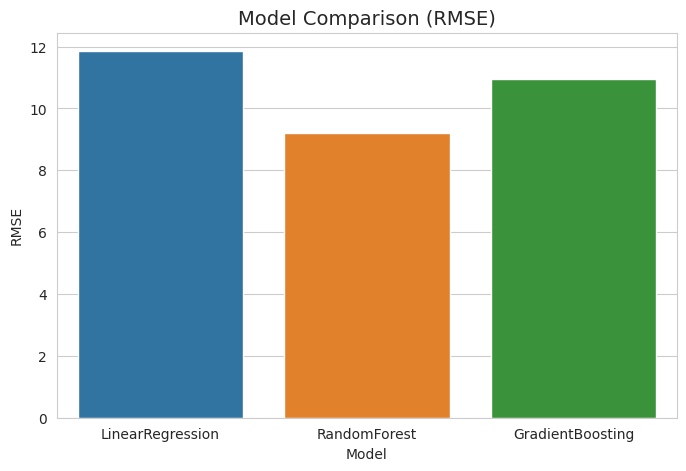

In [54]:
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="RMSE", data=results_df)
plt.title("Model Comparison (RMSE)", fontsize=14)
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


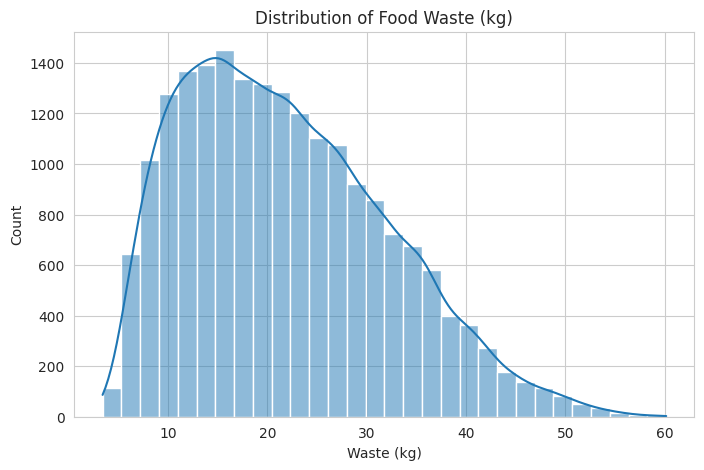

In [58]:
plt.figure(figsize=(8,5))
sns.histplot(final_df["waste_kg"], bins=30, kde=True)
plt.title("Distribution of Food Waste (kg)")
plt.xlabel("Waste (kg)")
plt.show()


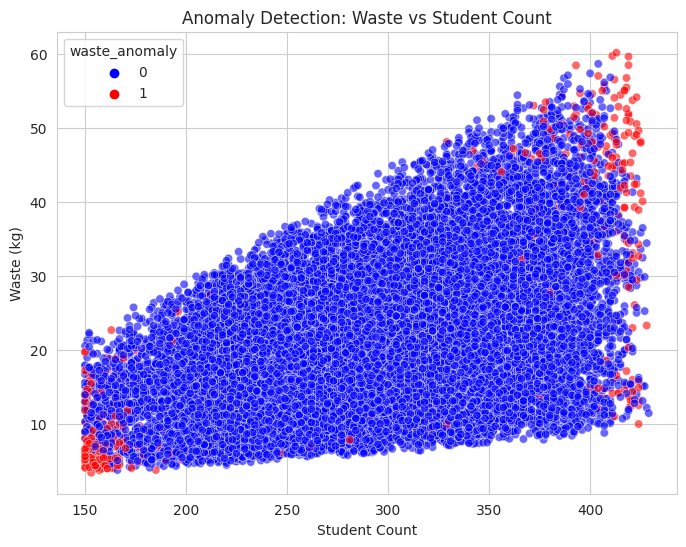

In [59]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=final_df["student_count"],
    y=final_df["waste_kg"],
    hue=final_df["waste_anomaly"],
    palette={0:"blue", 1:"red"},
    alpha=0.6
)

plt.title("Anomaly Detection: Waste vs Student Count")
plt.xlabel("Student Count")
plt.ylabel("Waste (kg)")
plt.show()


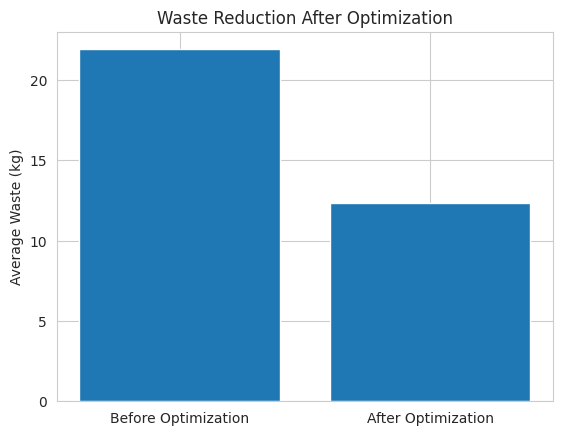

In [61]:
before_waste = final_df["waste_kg"].mean()
after_waste = opt_df["Expected_Waste"].mean()

plt.bar(["Before Optimization", "After Optimization"],
        [before_waste, after_waste])
plt.title("Waste Reduction After Optimization")
plt.ylabel("Average Waste (kg)")
plt.show()
